In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import random
from glob import glob 

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import *

In [ ]:
import os
os.chdir('/content/drive/MyDrive/데이콘/exercise_motion_classification/data/')

train=pd.read_csv('train_features.csv')
train_labels=pd.read_csv('train_labels.csv')
test=pd.read_csv('test_features.csv')
submission=pd.read_csv('sample_submission.csv')

In [ ]:
train.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


In [ ]:
x_train = []

for uid in tqdm(train['id'].unique()):
    temp = np.array(train[train['id'] == uid].iloc[:,2:], np.float32).T
    x_train.append(temp)

x_train = np.array(x_train, np.float32)
x_train = x_train[:,:,:,np.newaxis]

x_test = []

for uid in tqdm(test['id'].unique()):
    temp = np.array(test[test['id'] == uid].iloc[:,2:], np.float32).T
    x_test.append(temp)

x_test = np.array(x_test, np.float32)
x_test = x_test[:,:,:,np.newaxis]

100%|██████████| 782/782 [00:01<00:00, 604.82it/s]


In [ ]:
def aug(data, uid, shift = 0):
    shift_data = np.roll(data, shift, axis=2)

In [ ]:
for _ in range(10):
    aug(x_train, 0, int(random.random()*600))
    print('')

for _ in range(10):
    aug(x_test, 0, int(random.random()*600))
    print('')

x_train = x_train.reshape(-1,6)
x_test = x_test.reshape(-1,6)

x_train = train.iloc[:,2:]
x_test = test.iloc[:,2:]

x_train['id'] = train['id']
x_test['id'] = test['id']

def quantile_75(x):
  return x.quantile(q=0.75)

def quantile_25(x):
  return x.quantile(q=0.25)

features = ['id','acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']
X_train = x_train[features].groupby('id').agg(['max','min','mean','median','std',quantile_75,quantile_25])
X_test = x_test[features].groupby('id').agg(['max','min','mean','median','std',quantile_75,quantile_25])
y_train = train_labels['label']

In [ ]:
X_train.shape,y_train.shape

((3125, 42), (3125,))

In [ ]:
X_train.reset_index(inplace=True)
X_train.drop(['id'],axis=1,inplace=True)
X_train

acc_x                      ...        gy_z                        
           max       min      mean  ...         std quantile_75 quantile_25
0     1.344268  0.591940  0.931329  ...   25.275185   19.479614   -9.930266
1     1.234020 -2.156208 -0.766580  ...   75.545343   37.521852  -30.514605
2     1.219836 -1.142847  0.039836  ...   13.920337   10.915188   -4.718664
3    -0.622250 -1.417751 -0.887702  ...   23.647153    7.843401  -19.096905
4     0.599720 -2.429109 -0.659018  ...   46.148326   12.739489   -3.318290
...        ...       ...       ...  ...         ...         ...         ...
3120  0.390798 -1.624711 -0.300454  ...   24.913819    2.601295   -5.959514
3121 -0.446650 -1.575455 -0.974298  ...   12.786464    1.838386   -6.335722
3122  0.744666 -2.578974 -1.114246  ...  131.916609  110.101101 -119.508096
3123  0.915846 -0.929133 -0.111333  ...   71.243150   23.479180  -46.728375
3124  0.538809 -1.013813 -0.434048  ...   49.371117   42.920979  -50.133093

[3125 rows x 42 columns]

In [ ]:
X_test.reset_index(inplace=True)
X_test.drop(['id'],axis=1,inplace=True)
X_test

acc_x                      ...       gy_z                        
          max       min      mean  ...        std quantile_75 quantile_25
0   -0.275446 -1.564000 -1.018731  ...  12.251648    5.104833   -9.483683
1    0.627571 -1.929033 -0.522843  ...  61.604867   29.512729  -43.569149
2    2.972063 -0.792916  0.506947  ...  23.041463   12.942246  -13.266111
3    0.337281 -1.045889 -0.577603  ...  37.967372    8.768108   -9.005791
4    0.015642 -2.153047 -0.738640  ...  43.353007   28.747350  -12.864438
..        ...       ...       ...  ...        ...         ...         ...
777  0.427159 -2.050254 -0.907299  ...  68.462972   29.619127  -25.513229
778  1.659451 -1.709527 -0.608731  ...  81.398849   66.403974  -48.732587
779 -0.085249 -2.124959 -0.753193  ...  48.113344   15.890101  -20.144907
780  1.438345  0.536568  0.958903  ...  26.523530   25.126312  -21.297065
781  0.224194 -1.534616 -0.781752  ...  36.491662    6.547298  -21.046104

[782 rows x 42 columns]

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=1caa266b19f4a3d0dcc20b57c927a1b642a5e2e579a1c265b320c12e97c36535
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
# import BayesianOptimization as bysian_opt
from bayes_opt import BayesianOptimization
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

In [ ]:
def xgb_evaluate(max_depth, gamma,min_child_weight,max_delta_step,subsample,colsample_bytree,lambda_val,learning_rate):
    params = {'eval_metric': 'mlogloss',
              'objective': 'multi:softprob',
              'num_class' : 61,
              'max_depth': int(max_depth),
              'subsample': subsample,
              'eta': learning_rate,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,   
              'min_child_weight': min_child_weight ,
              'max_delta_step':max_delta_step,
              'lambda' : lambda_val
             }
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=200, nfold=3)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-mlogloss-mean'].iloc[-1]

In [ ]:
xgb_bo = BayesianOptimization(xgb_evaluate, {
                                    'max_depth': (2, 12),
                                     'gamma': (0.001, 10.0),
                                     'min_child_weight': (0, 20),
                                     'max_delta_step': (0, 10),
                                     'subsample': (0.4, 1.0),
                                     'colsample_bytree' :(0.4, 1.0),
                                     'lambda_val' : (1,5) ,
                                     'learning_rate': (0.01,0.2)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')

|   iter    |  target   | colsam... |   gamma   | lambda... | learni... | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -1.534    |  0.6146   |  9.426    |  4.007    |  0.1074   |  6.47     |  3.329    |  1.206    |  0.7503   |
|  2        | -1.422    |  0.9393   |  6.796    |  5.749    |  0.157    |  1.308    |  6.042    |  0.7364   |  0.942    |
|  3        | -1.755    |  0.9442   |  9.477    |  6.99     |  0.1489   |  7.751    |  6.628    |  2.386    |  0.6002   |
|  4        | -1.45     |  0.4      |  0.001    |  1.0      |  0.01     |  0.0      |  2.0      |  0.0      |  1.0      |
|  5        | -1.438    |  0.4      |  10.0     |  1.0      |  0.2      |  0.0      |  2.0      |  0.0      |  1.0      |
|  6        | -1.556    |  0.6141   |  6.062    |  4.649    |  0.108    |  0.2425   |  4.845    |  0.7194   |  0.9036   |
|  7        | -2.06     

In [ ]:
params = xgb_bo.max['params']

In [ ]:
params

In [ ]:
params['max_depth'] = 2
params['eval_metric'] = 'mlogloss'
params['objective'] = 'multi:softprob'
params['num_class'] = 61
params['lambda_val'] = 5 
params['learning_rate'] = 0.2 
params

In [ ]:
model = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=250,
    nfold=3,
    early_stopping_rounds=50,
    verbose_eval = 50
)

In [ ]:
# Fit
final_gb = xgb.train(params, dtrain, num_boost_round=200,verbose_eval=50)

preds = final_gb.predict(dtest)
preds

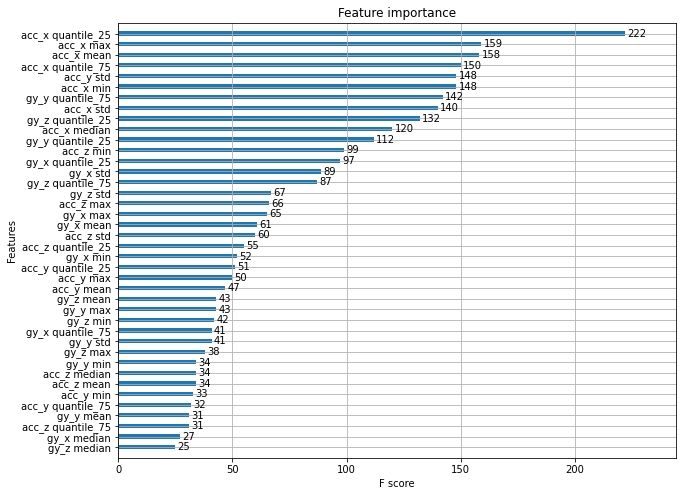

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(final_gb,ax=ax,max_num_features=40,height=0.4)

In [ ]:
submission.iloc[:,1:] = preds
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.005193,0.004942,0.004412,0.005314,0.005580,0.005335,0.003825,0.005576,0.005851,0.031965,0.161257,0.031194,0.003616,0.195240,0.011162,0.006427,0.005021,0.003560,0.003865,0.003058,0.005309,0.005800,0.005198,0.014432,0.178624,0.003759,0.027335,0.004402,0.003797,0.003563,0.012732,0.009091,0.015597,0.005004,0.008849,0.005745,0.028565,0.004194,0.003745,0.003956,0.005118,0.004560,0.004988,0.006492,0.004157,0.005201,0.004088,0.004314,0.009561,0.010927,0.006719,0.015444,0.003363,0.004126,0.004923,0.004751,0.004591,0.005946,0.027851,0.003558,0.007231
1,3126,0.001814,0.001344,0.001210,0.001605,0.002069,0.001451,0.001040,0.002409,0.001591,0.001767,0.001337,0.001620,0.000823,0.000956,0.001346,0.001748,0.001365,0.000968,0.001051,0.000832,0.001085,0.001976,0.002318,0.001875,0.001527,0.001022,0.913591,0.001191,0.001032,0.000969,0.001332,0.001299,0.001866,0.001361,0.002654,0.001562,0.001722,0.001140,0.001018,0.001076,0.001568,0.001575,0.001298,0.001765,0.001130,0.001262,0.001111,0.001173,0.001610,0.001960,0.002312,0.001551,0.000914,0.001113,0.001245,0.001292,0.001248,0.001947,0.001222,0.000967,0.001772
2,3127,0.007652,0.048819,0.005684,0.006829,0.005873,0.007774,0.004916,0.007228,0.007519,0.009299,0.006320,0.007655,0.003891,0.004518,0.007568,0.008260,0.009831,0.009358,0.004967,0.003930,0.005130,0.007517,0.006243,0.007524,0.007215,0.004830,0.111822,0.008729,0.005458,0.005304,0.006297,0.006138,0.008818,0.018983,0.009011,0.007383,0.008306,0.005390,0.004812,0.005083,0.012289,0.023298,0.006342,0.008342,0.008618,0.015131,0.005253,0.005544,0.008585,0.015397,0.008634,0.008084,0.004322,0.005259,0.011825,0.006106,0.013182,0.006457,0.005777,0.381892,0.011779
3,3128,0.001866,0.001382,0.001236,0.001486,0.002128,0.001492,0.001070,0.001528,0.002517,0.001453,0.001375,0.001491,0.000847,0.000983,0.001385,0.001797,0.001404,0.000995,0.001081,0.000855,0.001116,0.002167,0.001358,0.001637,0.001570,0.001051,0.900310,0.001231,0.001062,0.001539,0.001370,0.001336,0.003302,0.001399,0.002264,0.001607,0.002410,0.001173,0.001047,0.001106,0.001279,0.001275,0.002524,0.003074,0.001163,0.001298,0.001143,0.001206,0.001656,0.010349,0.003375,0.001595,0.000940,0.001144,0.001280,0.001329,0.001284,0.001385,0.001257,0.000995,0.002022
4,3129,0.002926,0.000984,0.000990,0.001033,0.001994,0.001062,0.000762,0.001245,0.001165,0.001159,0.000979,0.001062,0.000603,0.000700,0.000986,0.001662,0.001000,0.000709,0.001942,0.000609,0.000795,0.001183,0.004003,0.001166,0.001118,0.000855,0.930727,0.000877,0.000756,0.000710,0.000976,0.000951,0.001366,0.000996,0.001657,0.001144,0.001261,0.000835,0.000746,0.000788,0.001027,0.000908,0.000950,0.001293,0.000828,0.000924,0.000814,0.000859,0.001179,0.001444,0.003824,0.001136,0.000670,0.000815,0.000912,0.000946,0.000914,0.001172,0.000895,0.000709,0.001298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.006590,0.002302,0.002060,0.002475,0.038388,0.002817,0.001782,0.002776,0.002725,0.006553,0.004770,0.006673,0.001410,0.001726,0.002593,0.003887,0.002338,0.002390,0.007720,0.001424,0.002453,0.002768,0.007282,0.002727,0.004106,0.002019,0.779964,0.002050,0.001768,0.001660,0.008015,0.003782,0.005131,0.002330,0.005667,0.002676,0.003228,0.001953,0.001744,0.001842,0.003053,0.002124,0.003242,0.003023,0.001936,0.002161,0.001904,0.002009,0.002758,0.003351,0.004308,0.003141,0.001566,0.001922,0.002133,0.002213,0.002138,0.002866,0.002897,0.001657,0.003036
778,3903,0.002599,0.002255,0.001811,0.002466,0.003519,0.002510,0.001558,0.002427,0.002382,0.002646,0.002002,0.002171,0.001233,0.001432,0.002016,0.004314,0.002222,0.001449,0.002351,0.001245,0.002458,0.002935,0.003471,0.002384,0.002325

In [ ]:
# os.chdir('/content/drive/MyDrive/데이콘/exercise_motion_classification/submission/')
# submission.to_csv('xgb_model_ver5.csv', index=False)